In [17]:
# Libraries
import torch
import math
from tqdm import trange
from slips.distributions.mog import CircularMixture
from slips.samplers.smc import *
import matplotlib.pyplot as plt

In [18]:
# Make a Pytorch device
device = torch.device('cuda')

In [19]:
# Make the target distribution
target = CircularMixture(device)

In [20]:
# Get the score of the target distribution
def target_log_prob_and_grad(y):
    y_ = torch.autograd.Variable(y, requires_grad=True)
    log_prob_y = target.log_prob(y_)
    return log_prob_y, torch.autograd.grad(log_prob_y.sum(), y_)[0].detach()

In [25]:
# Hyper-parameters
n_particles = 4096
num_noise_levels = 512
n_mcmc_steps = 64
sigma = torch.tensor(5.0)

In [23]:
# Run the SMC algorithm
samples = smc_algorithm(n_particles=n_particles,
    target_log_prob=target.log_prob,
    target_log_prob_and_grad=target_log_prob_and_grad,
    init_sample=lambda n_samples : init_sample_gaussian(n_samples, sigma, 2, device),
    init_log_prob_and_grad=lambda x : init_log_prob_and_grad_gaussian(x, sigma),                  
    betas=torch.linspace(0.0, 1.0, num_noise_levels),
    n_mcmc_steps=n_mcmc_steps,
    verbose=True
).detach().cpu()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 511/511 [00:59<00:00,  8.63it/s]


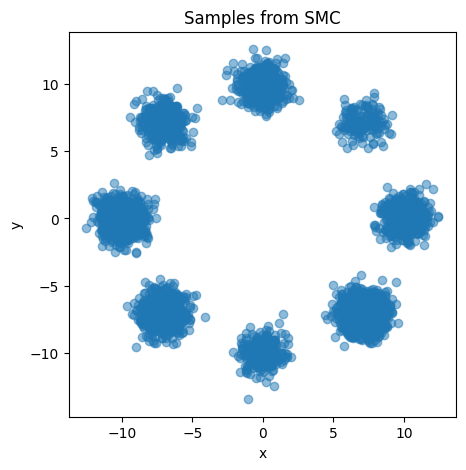

In [26]:
# Display samples
plt.figure(figsize=(5,5))
plt.scatter(samples[:,0], samples[:,1], alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Samples from SMC')
plt.show()

In [27]:
# Run the AIS algorithm
samples, weights = smc_algorithm(n_particles=n_particles,
    target_log_prob=target.log_prob,
    target_log_prob_and_grad=target_log_prob_and_grad,
    init_sample=lambda n_samples : init_sample_gaussian(n_samples, sigma, 2, device),
    init_log_prob_and_grad=lambda x : init_log_prob_and_grad_gaussian(x, sigma),                    
    betas=torch.linspace(0.0, 1.0, num_noise_levels),
    n_mcmc_steps=n_mcmc_steps,
    use_ais=True,
    verbose=True
)
samples, weights = samples.detach().cpu(), weights.detach().cpu()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 511/511 [00:59<00:00,  8.60it/s]


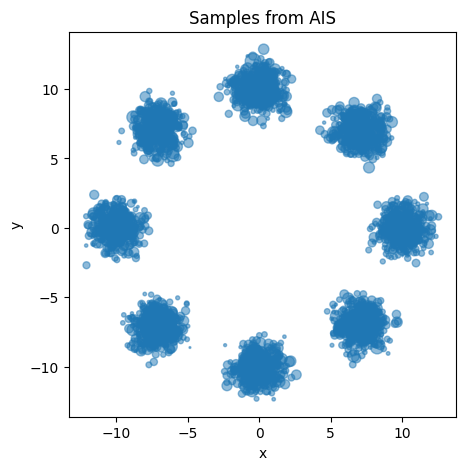

In [32]:
# Display samples
plt.figure(figsize=(5,5))
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, s=1e5*weights)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Samples from AIS')
plt.show()

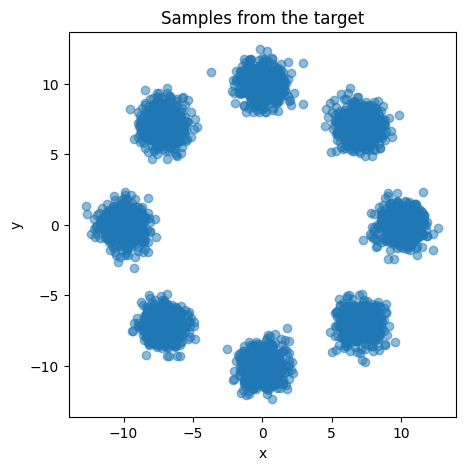

In [33]:
# Display target samples
plt.figure(figsize=(5,5))
target_samples = target.sample((samples.shape[0],)).cpu()
plt.scatter(target_samples[:,0], target_samples[:,1], alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Samples from the target')
plt.show()